<a href="https://colab.research.google.com/github/namanphy/END2/blob/main/S7/Part%201%20-%20sentiment%20classification/S7_SST_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis
Dataset : **Stanford Sentiment Treebank**

Steps covered in this notebook:
1. Knowing the data
2. Data preparation
3. Model Experiment
4. Result analysis


# Setting Up

In [6]:
# Uncomment if running on colab
! git clone https://github.com/namanphy/END2.git

Cloning into 'END2'...
remote: Enumerating objects: 393, done.
remote: Counting objects: 100% (393/393), done.
remote: Compressing objects: 100% (291/291), done.
remote: Total 393 (delta 180), reused 269 (delta 95), pack-reused 0
Receiving objects: 100% (393/393), 14.01 MiB | 13.46 MiB/s, done.
Resolving deltas: 100% (180/180), done.


In [7]:
cd /content/END2/S7/Part\ 1\ -\ sentiment\ classification

/content/END2/S7/Part 1 - sentiment classification


In [8]:
import os
import torch
import torch, torchtext
from torchtext.legacy import data 
import pandas as pd

from data import sentences_to_dataframe
from model import LSTM, BiLSTM, count_parameters
from trainer.loss import cross_entropy_loss
from trainer.optimizer import adam_optimizer
from trainer.train import train
from utils import binary_accuracy, plot_metric

# Manual Seed
SEED = 45
torch.manual_seed(SEED)



---



# Preparing the data

SST consists of 11,855 sentences extracted from movie reviews with fine-grained sentiment labels [1–5], as well as 215,154 phrases that compose each sentence in the dataset.


## Generating train and test sentence-label dataframes
From raw txt files..

In [9]:
df_train, df_test = sentences_to_dataframe(path_sst='./data/stanfordSentimentTreebank', seed=SEED)

In [10]:
print(df_train.shape)
print(df_test.shape)
df_train.head(2)

(9029, 3)
(2257, 3)


,sentence,sentiment labels,sentence_clean
0,"As violent , profane and exploitative as the m...",1,"As violent , profane and exploitative as the m..."
1,Ritchie 's film is easier to swallow than Wert...,1,Ritchie's film is easier to swallow than Wertm...


## Knowing our Data

Our dataset is ofcourse not balanced. It is clear that most of the training samples belong to classes 2 and 4. Also a good number of samples belong to `neutral` class i.e. label 3.


Text(0, 0.5, 'Number of Samples in training Set')

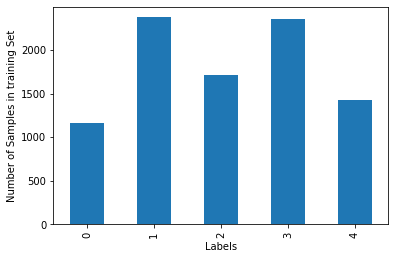

In [11]:
import matplotlib.pyplot as plt

ax = df_train['sentiment labels'].value_counts(sort=False).plot(kind='bar')
ax.set_xlabel("Labels")
ax.set_ylabel("Number of Samples in training Set")

What's the distribution of the lengths of the data ?

**It has a average of 102 in the training set.**

count    9029.000000
mean      100.714143
std        50.412797
min         4.000000
25%        61.000000
50%        96.000000
75%       134.000000
max       260.000000
dtype: float64

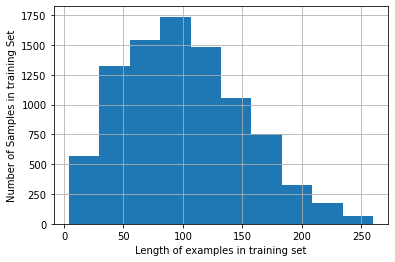

In [12]:
reviews_len = [len(x) for x in df_train['sentence_clean']]
ax = pd.Series(reviews_len).hist()
ax.set_xlabel("Length of examples in training set")
ax.set_ylabel("Number of Samples in training Set")
pd.Series(reviews_len).describe()

In [13]:
min(reviews_len)

4

## Making a torchtext dataset and dataloader

In [14]:
text = data.Field(sequential=True, tokenize='spacy', batch_first =True, include_lengths=True)
label = data.LabelField(sequential=False, tokenize ='spacy',  batch_first=True, is_target=True)

In [15]:
fields = [('texts', text), ('labels', label)]

In [16]:
# Generated Examples from the train and test data

train_example = [data.Example.fromlist([df_train['sentence_clean'][i], df_train['sentiment labels'][i]], fields) for i in range(df_train.shape[0])]
test_example = [data.Example.fromlist([df_test['sentence_clean'][i], df_test['sentiment labels'][i]], fields) for i in range(df_test.shape[0])]

#### Building Dataset

In [17]:
train_dataset = data.Dataset(train_example, fields)
test_dataset = data.Dataset(test_example, fields)

In [18]:
print('Length of training dataset: ', len(train_dataset))
print('Length of testing dataset: ', len(test_dataset))

Length of training dataset:  9029
Length of testing dataset:  2257


#### Building Vocab

In [19]:
text.build_vocab(train_dataset)
label.build_vocab(train_dataset)

In [20]:
print('Size of input vocab : ', len(text.vocab))
print('Size of label vocab : ', len(label.vocab))
print('Top 10 words appreared repeatedly :', list(text.vocab.freqs.most_common(10)))
print('Labels : ', label.vocab.stoi)

Size of input vocab :  17490
Size of label vocab :  5
Top 10 words appreared repeatedly : [('.', 8511), (',', 7523), ('the', 6384), ('and', 4674), ('of', 4639), ('a', 4574), ('to', 3160), ('-', 2920), ('is', 2656), ("'s", 2615)]
Labels :  defaultdict(None, {1: 0, 3: 1, 2: 2, 4: 3, 0: 4})


**Lots of stopwords!! YES INDEED!!**

#### Making a data iterator

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [22]:
train_iterator, test_iterator = data.BucketIterator.splits((train_dataset, test_dataset), 
                                                           batch_size=128, 
                                                           sort_key=lambda x: len(x.texts),
                                                           sort_within_batch=True,
                                                           device=device)

**Notice that i haven't used padding for my sentences(data) here.**

In [23]:
print('Train')
for batch in train_iterator:
    print(f'Text size: {batch.texts[0].size()}')
    print(f'Label size: {batch.labels.size()}')
    break

print('\nTest:')
for batch in test_iterator:
    print(f'Text size: {batch.texts[0].size()}')
    print(f'Label size: {batch.labels.size()}')
    break

Train
Text size: torch.Size([128, 15])
Label size: torch.Size([128])

Test:
Text size: torch.Size([128, 6])
Label size: torch.Size([128])


In [24]:
import pickle
with open('tokenizer.pkl', 'wb') as tokens: 
    pickle.dump(text.vocab.stoi, tokens)

# Model Preparation

In [25]:
import torch.nn as nn
import torch.nn.functional as F

In [34]:
# Hyperparams

size_of_vocab = len(text.vocab)
embedding_dim = 400
num_hidden_nodes = 150
num_output_nodes = 5
num_layers = 3
dropout = 0.2

model = BiLSTM(size_of_vocab, embedding_dim, num_hidden_nodes, num_output_nodes, num_layers, dropout)

In [35]:
print(model)
print(f'The model has {count_parameters(model):,} trainable parameters')

BiLSTM(
  (embedding): Embedding(17490, 400)
  (lstm): LSTM(400, 150, num_layers=3, batch_first=True, dropout=0.2, bidirectional=True)
  (fc): Linear(in_features=300, out_features=5, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
The model has 8,744,705 trainable parameters


# Training

In [36]:
optimizer = adam_optimizer(model, lr=0.001)  # TODO: lr=0.001
criterion = cross_entropy_loss()

model = model.to(device)
# criterion = criterion.to(device)

In [37]:
train_losses, test_losses, train_accuracies, test_accuracies = train(model, 
                                                                     train_iterator, 
                                                                     test_iterator, 
                                                                     optimizer, 
                                                                     criterion,
                                                                     binary_accuracy,
                                                                     epochs=20)

True
Epoch: 01 | Epoch Time: 0m 1s
	Train Loss: 1.578 | Train Acc: 27.17%
	 Val. Loss: 1.564 |  Val. Acc: 29.67% 

Epoch: 02 | Epoch Time: 0m 1s
	Train Loss: 1.545 | Train Acc: 34.41%
	 Val. Loss: 1.535 |  Val. Acc: 34.71% 

Epoch: 03 | Epoch Time: 0m 1s
	Train Loss: 1.487 | Train Acc: 40.63%
	 Val. Loss: 1.527 |  Val. Acc: 36.13% 

Epoch: 04 | Epoch Time: 0m 1s
	Train Loss: 1.427 | Train Acc: 47.49%
	 Val. Loss: 1.526 |  Val. Acc: 35.42% 

Epoch: 05 | Epoch Time: 0m 1s
	Train Loss: 1.366 | Train Acc: 54.21%
	 Val. Loss: 1.525 |  Val. Acc: 36.57% 

Epoch: 06 | Epoch Time: 0m 1s
	Train Loss: 1.318 | Train Acc: 59.11%
	 Val. Loss: 1.529 |  Val. Acc: 35.90% 

Epoch: 07 | Epoch Time: 0m 1s
	Train Loss: 1.266 | Train Acc: 64.42%
	 Val. Loss: 1.510 |  Val. Acc: 38.29% 

Epoch: 08 | Epoch Time: 0m 1s
	Train Loss: 1.233 | Train Acc: 67.57%
	 Val. Loss: 1.521 |  Val. Acc: 36.80% 

Epoch: 09 | Epoch Time: 0m 1s
	Train Loss: 1.196 | Train Acc: 71.21%
	 Val. Loss: 1.522 |  Val. Acc: 37.07% 

Epoch

# Evaluation

In [42]:
print('Best Test Accuracy reached : ', max(test_accuracies)*100)

Best Test Accuracy reached :  38.287680016623604


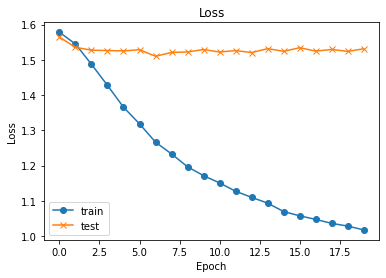

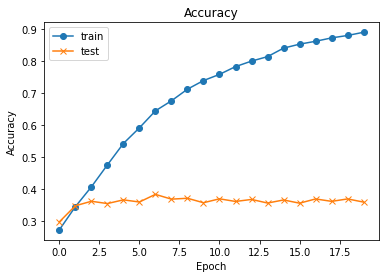

In [38]:
plot_metric([train_losses, test_losses], ['train', 'test'], 'Epoch', 'Loss', 'Loss')
print('\n')
plot_metric([train_accuracies, test_accuracies], ['train', 'test'], 'Epoch', 'Accuracy', 'Accuracy')

## Finding misclassified texts

In [39]:
categories = {0: "Big Negative", 1:"Negative", 2:"Neutral", 3:"Positive", 4:"Big Positive"}

j = 0
for batch in test_iterator:
    # pred = classify_tweet('I am very negative negative negaive')

    pred_label = batch.labels
    pred_texts, pred_text_lengths = batch.texts
    pred_text, pred_text_length = pred_texts[0], pred_text_lengths[0]
    # print(pred_text, pred_text_length)

    # Get the model prediction                  
    prediction = model(pred_text.unsqueeze(0), pred_text_length.unsqueeze(0))
    _, pred = torch.max(prediction, 1) 

    print('Sentence : ', ' '.join([text.vocab.itos[x] for x in list(pred_text)]))
    print('\tPredicted Label : ', categories[pred.item()])
    print('\tCorrect Label   : ', categories[pred_label[0].item()])
    
    if j > 12:
        break

Sentence :  <unk> eventually <unk> the <unk> .
	Predicted Label :  Big Negative
	Correct Label   :  Neutral
Sentence :  A cinematic sleeping pill of impressive potency .
	Predicted Label :  Positive
	Correct Label   :  Neutral
Sentence :  It 's a sharp movie about otherwise dull subjects .
	Predicted Label :  Neutral
	Correct Label   :  Negative
Sentence :  You watch for that sense of openness , the little surprises .
	Predicted Label :  Negative
	Correct Label   :  Negative
Sentence :  The only fun part of the movie is playing the obvious game .
	Predicted Label :  Neutral
	Correct Label   :  Big Negative
Sentence :  Film ca n't quite maintain its initial momentum , but remains sporadically funny throughout .
	Predicted Label :  Neutral
	Correct Label   :  Neutral
Sentence :  <unk> to sort the bad guys from the good , which is its essential problem .
	Predicted Label :  Big Negative
	Correct Label   :  Big Negative
Sentence :  It 's about individual moments of mood , and an aimlessnes

## Cnfusion Matrix

### Inferring all test data

In [50]:
import spacy
nlp = spacy.load('en')

path='../weights/best_model.pt'
model.load_state_dict(torch.load(path));
model.eval();
tokenizer_file = open('./tokenizer.pkl', 'rb')
tokenizer = pickle.load(tokenizer_file)

print("Model and Tokenizer Loaded!")

def classify_tweet(text):
    
    categories = {0: "Big Negative", 1:"Negative", 2:"Neutral", 3:"Positive", 4:"Big Positive"}
    
    # tokenize the tweet 
    tokenized = [tok.text for tok in nlp.tokenizer(text)] 
    indexed = [tokenizer[t] for t in tokenized]        
    length = [len(indexed)]
    tensor = torch.LongTensor(indexed).to(device)   

    tensor = tensor.unsqueeze(1).T  
    length_tensor = torch.LongTensor(length)

    prediction = model(tensor, length_tensor)
    pred = torch.argmax(prediction, 1) 
    
    return categories[pred.item()]

Model and Tokenizer Loaded!


In [ ]:
# Predicting all sentences
df_test['predictions'] = df_test['sentence_clean'].apply(classify_tweet)

In [52]:
df_test['predictions'].value_counts()

Negative        949
Big Negative    830
Neutral         283
Positive        195
Name: predictions, dtype: int64

### Plot



In [58]:
from sklearn.metrics import confusion_matrix
import numpy as np


def plot_confusion_matrix(y_true, y_pred, classes=["Big Negative", "Negative", "Neutral", "Positive", "Big Positive"], 
                          cmap=plt.cm.YlOrBr):

    cm = confusion_matrix(y_true, y_pred)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', origin='lower', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           ylabel='True label',
           xlabel='Predicted label')
    
    plt.setp(ax.get_xticklabels(), rotation=30, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    return fig, ax

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe00450ea10>)

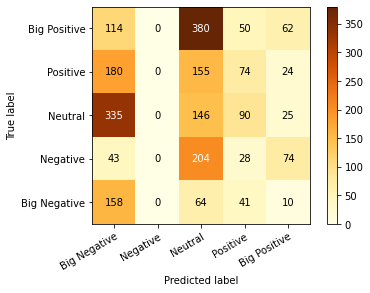

In [59]:
categories = {0: "Big Negative", 1:"Negative", 2:"Neutral", 3:"Positive", 4:"Big Positive"}
plot_confusion_matrix(df_test['sentiment labels'].apply(lambda x: categories[x]).values.tolist(), df_test['predictions'].values.tolist())